In [3]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt

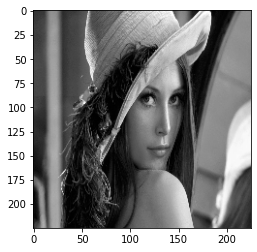

(225, 225)

In [4]:
img = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE)/255
img = cv2.resize(img, (225,225))
plt.imshow(img, cmap='gray')
plt.show()
img.shape

In [5]:
class convolution_op:
  def __init__(self, num_filters, filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size * filter_size)

  def image_region(self, image):
    height, width = image.shape
    self.image =  image
    for j in range(height - self.filter_size + 1):
      for k in range(width - self.filter_size + 1):
        image_patch = image[j : (j + self.filter_size), k :(k + self.filter_size)]
        yield image_patch, j, k
    
  def forward_propogation(self, image):
    height, width = image.shape
    conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
    for image_patch, i, j in self.image_region(image):
      conv_out[i,j] = np.sum(image_patch*self.conv_filter, axis=(1,2))
    return conv_out

  def back_propogation(self, dL_dout, learning_rate):
    dL_dF_params = np.zeros(self.conv_filter.shape)
    for image_patch, i, j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch*dL_dout[i,j,k]

    #Filter parameters updation
    self.conv_filter -= learning_rate * dL_dF_params
    return dL_dF_params



(219, 219, 18)


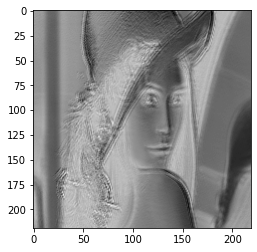

In [6]:
conn = convolution_op(18,7)
out = conn.forward_propogation(img)
print(out.shape)

plt.imshow(out[:, :, 17], cmap='gray')
plt.show()

In [7]:
class max_pool:
  def __init__(self, filter_size):
    self.filter_size = filter_size
  
  def image_region(self, image):
    new_height = image.shape[0] // self.filter_size 
    new_width = image.shape[1] // self.filter_size
    self.image = image

    for i in range(new_height):
      for j in range(new_width):
        image_patch = image[(i*self.filter_size): (i*self.filter_size + self.filter_size), (j*self.filter_size): (j*self.filter_size + self.filter_size) ]
        yield image_patch, i, j
      
  def forward_propogation(self, image):
    height, width, num_filters =  image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    for image_patch, i, j in self.image_region(image):
      output[i, j] = np.amax(image_patch, axis = (0, 1))

    return output

  def back_propogation(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch, axis=(0,1))

      for i1 in range(height):
        for j1 in range(width):
          for k1 in range(num_filters):
            if image_patch[i1, j1, k1] == maximum_val[k1]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] =  dL_dout[i, j, k1]
      return dL_dmax_pool


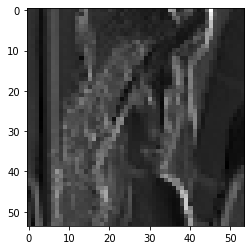

In [8]:
conn2 = max_pool(4)
out2 = conn2.forward_propogation(out)
out2.shape

plt.imshow(out2[:, :, 14], cmap='gray')
plt.show()

In [9]:
class Softmax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_propogation(self, image):
    self.orig_im_shape = image.shape      # Used during Backpropogation
    image_modified = image.flatten()
    self.modified_input = image_modified  # Used in Backpropogation
    output_val = np.dot(image_modified, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)

    return exp_out/np.sum(exp_out, axis = 0)

  def back_propogation(self, dL_dout, learning_rate):
    for i, grad in enumerate(dL_dout):
      if grad == 0:
        continue
      
      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      #Gradients with respect to output (Z)
      dy_dz = -transformation_eq[i] * transformation_eq / (S_total **2)
      dy_dz[i] = transformation_eq[i] * (S_total - transformation_eq[i]) / (S_total **2)

      #Gradients of totals against weights/biases/input
      dz_dw = self.modified_input 
      dz_db = 1
      dz_d_inp = self.weight

      #Gradients of loss against totals
      dL_dz = grad * dy_dz

      #Gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp = dz_d_inp @ dL_dz

      #Update the weight and biases
      self.weight -= learning_rate * dL_dw
      self.bias -= learning_rate * dL_db

    return dL_d_inp.reshape(self.orig_im_shape)


In [10]:
conn3 = Softmax(54*54*18, 10)
out3 = conn3.forward_propogation(out2)
print(out3)

[0.09998677 0.10002283 0.10003482 0.10000391 0.09998262 0.09995617
 0.10001357 0.09998403 0.10002474 0.09999054]


In [11]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_images = X_train
train_labels = y_train
test_images = X_test
test_labels = y_test

conv = convolution_op(8,3)
pool = max_pool(2)
softmax = Softmax(13*13*8, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [12]:
 def cnn_forward_propogation(image, label):

   out_p = conv.forward_propogation((image/255) - 0.5)
   out_p = pool.forward_propogation(out_p)
   out_p = softmax.forward_propogation(out_p)

   #Calculate the cross-entropy loss and accuracy
   cross_ent_loss = -np.log(out_p[label])
   accuracy_eval = 1 if np.argmax(out_p) == label else 0

   return out_p, cross_ent_loss, accuracy_eval



In [13]:
#Training or backpropogation
def training_cnn(image, label, learn_rate = .005):
  #Forward
  out, loss, acc = cnn_forward_propogation(image, label)

  #Calculate Initial Gradient 
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  #Backward
  grad_back = softmax.back_propogation(gradient, learn_rate)
  grad_back = pool.back_propogation(grad_back)
  grad_back = conv.back_propogation(grad_back, learn_rate)

  return loss, acc 

In [14]:
for epoch in range(10):
  print('Epoch %d ---> ' % (epoch + 1))

  #Shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  #Training the CNN
  loss = 0
  num_correct = 0

  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 0:
      print('%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%' %(i+1, loss/100, num_correct))
      loss = 0
      num_correct = 0

    l1, accu = training_cnn(im, label)
    loss += l1
    num_correct += accu

Streaming output truncated to the last 5000 lines.
40901 steps out of 100 steps: Average Loss 0.279 and Accuracy: 93%
41001 steps out of 100 steps: Average Loss 0.398 and Accuracy: 90%
41101 steps out of 100 steps: Average Loss 0.346 and Accuracy: 93%
41201 steps out of 100 steps: Average Loss 0.375 and Accuracy: 89%
41301 steps out of 100 steps: Average Loss 0.479 and Accuracy: 86%
41401 steps out of 100 steps: Average Loss 0.354 and Accuracy: 93%
41501 steps out of 100 steps: Average Loss 0.359 and Accuracy: 91%
41601 steps out of 100 steps: Average Loss 0.277 and Accuracy: 95%
41701 steps out of 100 steps: Average Loss 0.316 and Accuracy: 95%
41801 steps out of 100 steps: Average Loss 0.295 and Accuracy: 93%
41901 steps out of 100 steps: Average Loss 0.257 and Accuracy: 94%
42001 steps out of 100 steps: Average Loss 0.296 and Accuracy: 92%
42101 steps out of 100 steps: Average Loss 0.317 and Accuracy: 91%
42201 steps out of 100 steps: Average Loss 0.434 and Accuracy: 87%
42301 steps

In [15]:
#Testing the CNN
print('**Testing Phase')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l1, accu = cnn_forward_propogation(im, label)
  loss += l1
  num_correct += accu

num_tests = len(test_images)
print('Test Loss: ', loss/num_tests)
print('Test Accuracy: ', num_correct/num_tests)

**Testing Phase
Test Loss:  0.21905659938150207
Test Accuracy:  0.938
